In [188]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import bspline
from bspline import splinelab
import warnings
from scipy.special import assoc_laguerre
import seaborn as sns
import pandas as pd
warnings.filterwarnings("ignore")
sns.set()
z= 1
def expspace(initial,final,num):
    start = np.log(initial+abs(initial)+1)
    end = np.log(final+abs(initial)+1)
    x = np.linspace(start,end,num)
    return np.exp(x)-abs(initial)-1
def radial_wavefunction(x, n, l, z):
    prefac = (2.0 * z / n) ** 3 / 2.0 / n / np.prod(range(n - l, n + l + 1))
    return (
        -np.sqrt(prefac)
        * np.exp(-z * x / n)
        * (2.0 * z * x / n) ** l
        * assoc_laguerre(2.0 * z * x / n, n - l - 1, k=2.0 * l + 1.0)
    )

def eigenvectorplot(n,l,n_eigenvectors,xmin,xmax,p= 3,R_min= 0 ,R_max = 1000):
    r = np.linspace(R_min,R_max,10000)
    eigvecs = np.load(f"Eigen\Eigenvectors_n={n}_l={l}.npy").T
    knots = expspace(R_min, R_max,n)
    k = splinelab.augknt(knots,p)
    B = bspline.Bspline(k,p)
    b_splines = np.array([B(t) for t in r]) 
    b_splines = np.delete(b_splines,[-1], axis=1)
    b_splines = np.delete(b_splines,[0], axis=1)
    #eigvecs = np.insert(eigvecs,[0],0,axis = 1)
    #eigvecs = np.insert(eigvecs,[-1],0,axis = 1)
    for index,element in enumerate(eigvecs):
        y = b_splines@(element.T)
        b = normalize(r,y)
        plt.plot(r,b,label = f"Eigenvector {index}")
        plt.plot(r,radial_wavefunction(r,index+1+l,l,1),"--",label = f"Analytical {index}")
        #plt.plot(knots, element/knots)
        if index == n_eigenvectors-1:
            break
    
    #plt.plot(radial_wavefunction(r,1,l,z),label = "Analytical")
    #plt.plot(radial_wavefunction(r,))
    #plt.grid()
    plt.xlim(xmin,xmax)
    plt.title(f"Wave Functions with l = {l}, n = {n}")    
    plt.xlabel("Distance(r)")
    plt.ylabel(r"$\psi_n(r) a_0^{-3/2}$")
    plt.legend()
    
def integrate(x, y):
    return np.sum((y[1:] + y[:-1]) * (x[1:] - x[:-1])) / 2


def normalize(x, y):
    mask = x > 0
    prop_density = y[mask] ** 2
    N = integrate(x[mask], prop_density)
    if y[1] < 0:
        return y / x / np.sqrt(N)
    return -y / x / np.sqrt(N)
for l in range(0,10):
    globals()[f"l{l}_Df"] = pd.DataFrame()
    globals()[f"l{l}_Df"]["Theoretical"] = [-1/(n+l)**2/2 for n in range(1,11)]
    for a in range(10,100,10):
        globals()[f"l{l}_Df"][f"n = {a}"] =  list(np.load(f"Eigen/Eigenvalues_n={a}_l={l}.npy")[:10])
df = pd.DataFrame()
df["Time_B"] = np.load("Performance.npy")[0]
df["Time_H"] = np.load("Performance.npy")[1]
df["x"] = range(10,100,5)
hide_toggle()

# Bsplines Hydrogen Atom

## 1.Introduction

The task of the assignment is to solve schrödinger equation as an eigenvalue problem using B-Splines. For this first we need to see how we mannipulate Schrödinger equation in order to solve the problem using B-Splines. 
<br>
During the course we've already seen how B-Splines are defined so we can move straight to the application of them. We want to solve the following equation:
$$H\Psi(x) = E \Psi(x)$$
For that we first expand the wavefunction using B-Splines:
$$\Psi(x) = \sum_{i}c_{i}B_{i,k} $$
Introducing this in the time independent schrödinger equation:
$$H \sum_{i}c_{i}B_{i,k} = E \sum_{i}c_{i}B_{i,k}$$
Now we multiply by $B_{j,k}$ and integrate in both sides and get:
$$\sum_{i}c_{i} \int_{t_{first}}^{t_{last}}B_{j,k}HB_{i,k} = E \sum_{i}c_{i}\int_{t_{first}}^{t_{last}}B_{j,k}B_{i,k} $$
Where t here are the correspond to the first and last knotpoint. We have transformed our problem succesfuly to a generalized Eigenvalue problem, that I solve using scipy.integrate.quadrature:
$$Hc = EBc$$
And now getting all matrix elements for H,B integrating we can solve this generalized eigenvalue problem and get the corresponding eigenvalues and eigenvectors.
### 1.1 Integration method
For this problem we are using Gaussian Integration. A brief summary of the method:
- We want to integrate the following for each element of our matrices $H,B$:
$$ H_{i,j} = \int_{t_{first}}^{t_{last}}B_{j,k}HB_{i,k}\quad \quad \quad B_{i,j} = \int_{t_{first}}^{t_{last}}B_{j,k}B_{i,k} $$
- Gaussian integration means:
$$\int_{-1}^1 f(x)\,dx \approx \sum_{i=1}^n w_i f(x_i)$$
Since we are using arbitrary integration limits a transform has to be done first, which is included inside the scipy package:
$$\int_a^b f(x)\,dx = \int_{ -1}^1 f\left(\frac{b-a}{2}\xi + \frac{a+b}{2}\right)\,\frac{dx}{d\xi}d\xi $$
- But since we are using B-Splines we can divide this further so that we don't need that many points and speed up the process dividing the integrals between knotpoints in the following way:
$$\sum_{m= max(i,j)}^{min(i,j)+k-1} \int_{r =t_{m}}^{t_{m}+1} B_{j,k}HB_{i,k} =\sum_{m= max(i,j)}^{min(i,j)+k-1}\sum_{n=1}^{k}\omega_{n}f(r_{n_{m}}$$


## 2. Eigenvalue results
- The analytical solution of the eigenvalues for the radial part is $$E_{n} = \frac{1}{(n+l)^{2}}$$
- I solved the equation for l= [0,1,2,3,4,5,6,7,8,9,10] and using n = [10,20,30,40,50,60,70,80,90,100] exponentialy spaced knotpoints.
### 2.1 l= 0
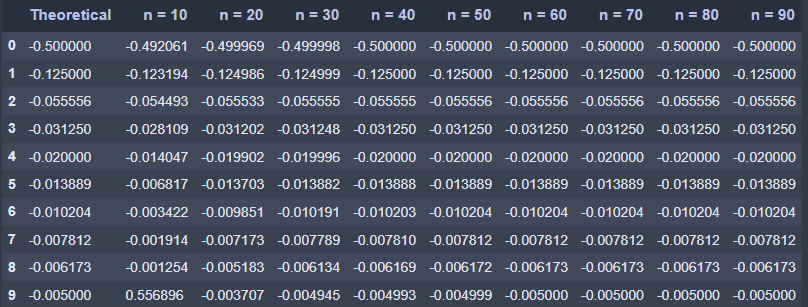
### 2.2 l = 1
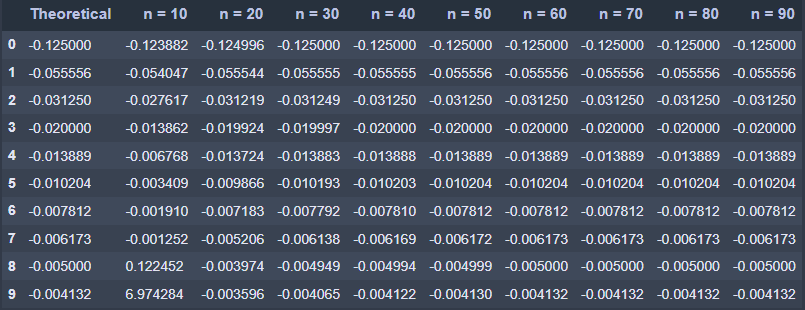
### l =2
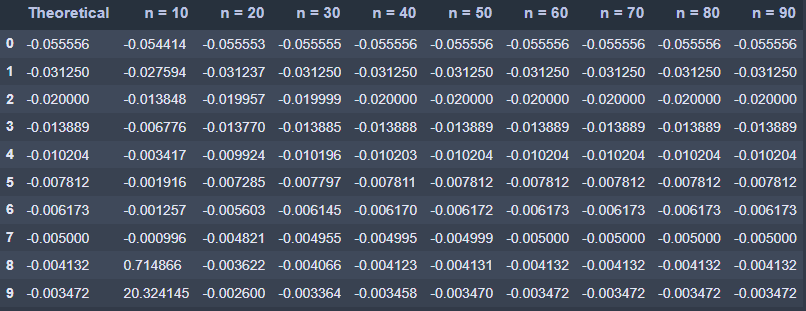
### l = 3
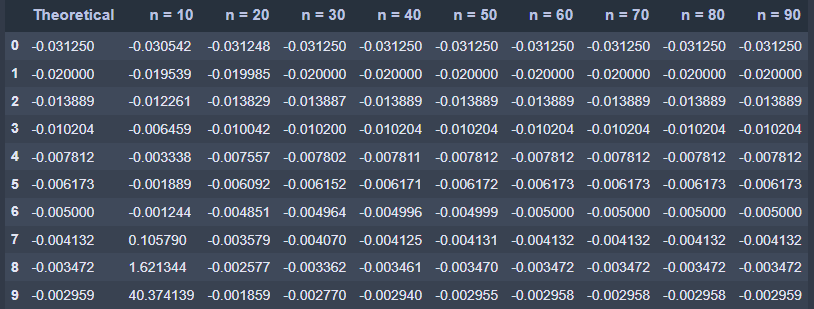
### l = 4
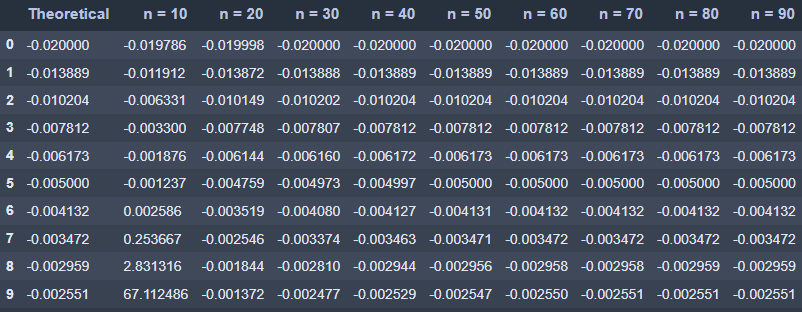
### l = 5
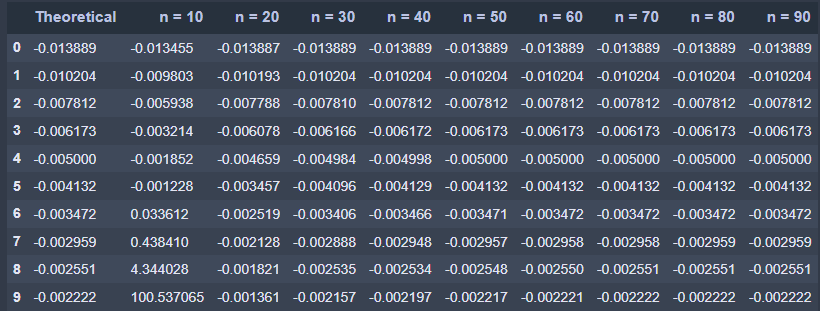
### l = 6
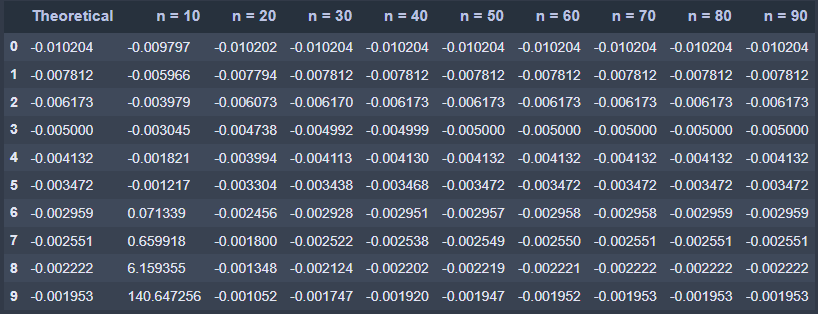
### l = 7
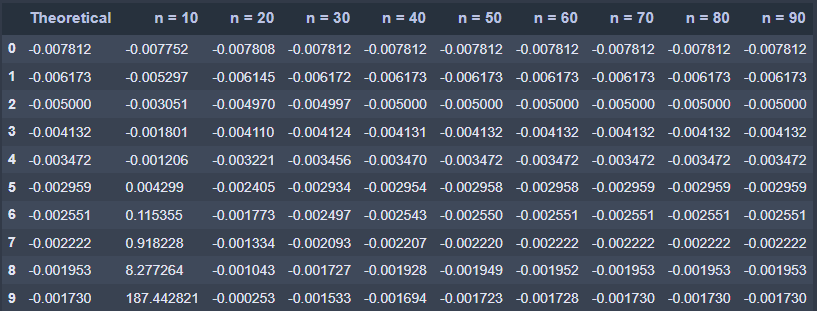
### l = 8
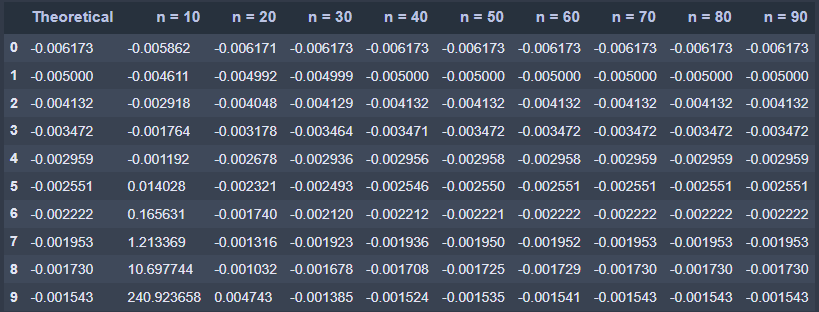
### l = 9
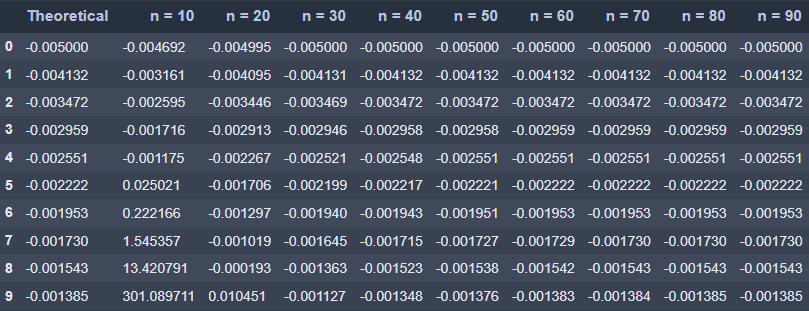    

We mainly observe two things:
- The eigenvalues converge as we increase the number of knotpoints and the higher the l the more knotpoints we need in order to converge to the right value.
- The first eigenvalue of l is the same as the second eigenvalue for l-1 which is what was expected
- We can also check for higher energies if we get the right eigenvalues (I will directly check with l = 9 and n = 90
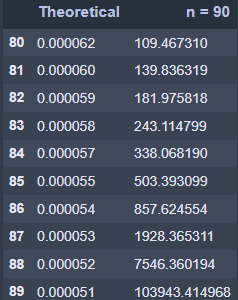
- So for very high energy we get poor eigenvalues.The last correct eigenvalues:
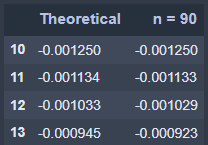
- To compare with lower angular momentum l  = 0 we get the right eigenvalues till:


## 3. Eigenvectors
- I also get exactly the right wave functions with 60 knotpoints
- We can observe how the valleys go further away as we increase the angular momentum which is what is expected


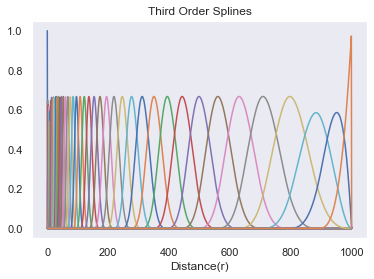

In [176]:
x = np.linspace(0,1000,1000)
# Lista de b splines
k = splinelab.augknt(knots,p)
B = bspline.Bspline(k,p)
b_splines = np.array([B(t) for t in x]) 
b_splines = b_splines.T
for a,b in enumerate(b_splines):
    plt.plot(x,b,label = f"{a+1}")
plt.grid()
plt.title("Third Order Splines")
plt.xlabel("Distance(r)")

plt.savefig("SplinesPlot.pdf")
hide_toggle()

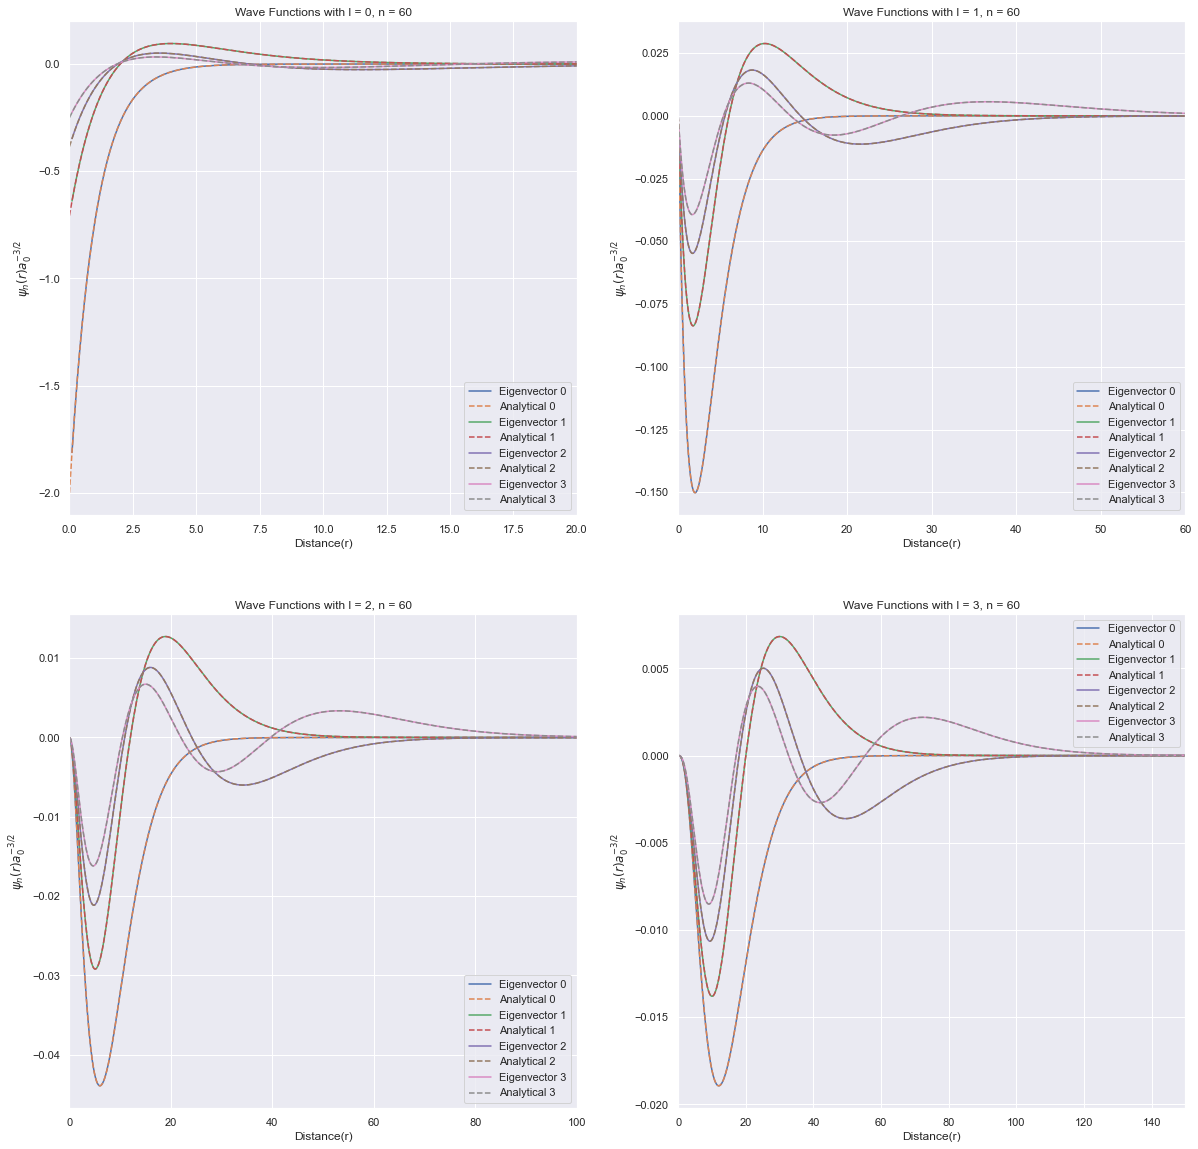

In [173]:
fig = plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
eigenvectorplot(60,0,4,0,20)
plt.subplot(2,2,2)
eigenvectorplot(60,1,4,0,60)
plt.subplot(2,2,3)
eigenvectorplot(60,2,4,0,100)
plt.subplot(2,2,4)
eigenvectorplot(60,3,4,0,150)

hide_toggle()

## 4. Performance
Here I lay out a plot to see how the filling of the matrix scales with the number of knotpoints.

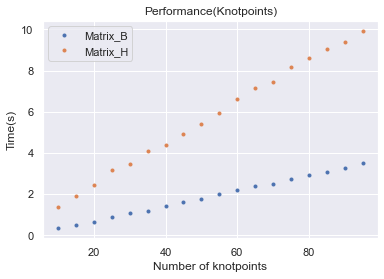

In [186]:
plt.plot(df["x"],df["Time_B"],".", label = "Matrix_B")
plt.plot(df["x"], df["Time_H"],".", label = "Matrix_H")
plt.xlabel("Number of knotpoints")
plt.ylabel("Time(s)")
plt.legend()
plt.title("Performance(Knotpoints)")
hide_toggle()